In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from itertools import permutations
from tqdm import tqdm
import pylab
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def bar_to_coord(point):
    if (len(point) != 3):
        print("WRONG DIMENSION")
        return
    point = point / np.sum(point)
    return np.array([0, 0]) * point[0] + np.array([1, 0]) * point[1] + np.array([0, 1]) * point[2]

def bar_to_triag(point):
    if (len(point) != 3):
        print("WRONG DIMENSION")
        return
    point = point / np.sum(point)
    return np.array([0, 0]) * point[0] + np.array([1, 0]) * point[1] + np.array([0.5, np.sqrt(3) / 2]) * point[2]

def get_area(triag): # return renormalized triangle area
    p1 = bar_to_triag(triag[0])
    p2 = bar_to_triag(triag[1])
    p3 = bar_to_triag(triag[2])
    
    return 0.5 * abs((p2[0] - p1[0]) * (p3[1] - p1[1]) - (p3[0] - p1[0]) * (p2[1] - p1[1])) / (np.sqrt(3) / 4)

def is_inside(point, triag, e_num): # says if point is inside triag
    coefs = np.linalg.solve(triag.T, point)
    if np.min(coefs) > -e_num:
        return True
    return False

def tr_is_inside(triag1, triag, e_num):
    return is_inside(triag1[0], triag, e_num) and is_inside(triag1[1], triag, e_num) and is_inside(triag1[2], triag, e_num)

In [3]:
M_321 = np.array([[1, 1, 1], [0, 1, 1], [0, 0, 1]])
M_312 = np.array([[1, 0, 1], [1, 1, 1], [0, 0, 1]])
M_231 = np.array([[1, 1, 1], [0, 1, 0], [0, 1, 1]])
M_213 = np.array([[1, 1, 0], [0, 1, 0], [1, 1, 1]])
M_132 = np.array([[1, 0, 0], [1, 1, 1], [1, 0, 1]])
M_123 = np.array([[1, 0, 0], [1, 1, 0], [1, 1, 1]])

def F(x): # BRUN
    if (len(x) != 3):
        print("WRONG DIMENSION")
        return
    x = x / np.sum(x)
    # Choosing proper matrix
    if x[0] >= x[1] >= x[2]: # CODE: 321
#         print("321")
        M = M_321
    elif x[1] >= x[0] >= x[2]:
#         print("312")
        M = M_312
    elif x[0] >= x[2] >= x[1]:
#         print("231")
        M = M_231
    elif x[1] >= x[2] >= x[0]:
#         print("132")
        M = M_132
    elif x[2] >= x[1] >= x[0]:
#         print("123")
        M = M_123
    elif x[2] >= x[0] >= x[1]:
#         print("213")
        M = M_213
    res = np.dot(np.linalg.inv(M), np.transpose(x))
    return res / np.sum(res)

def stab_vert(vert1, vert2, vert3, e_num):
    if abs(np.sort(vert1)[2] - np.sort(vert1)[1]) > e_num and abs(np.sort(vert1)[1] - np.sort(vert1)[0]) > e_num:
        return vert1
    else:
        res = vert1 + (vert2 + vert3) * e_num ** 2
        return res / np.sum(res)

def F_tr(triag, e_num):
    res = []
    v1 = triag[0]
    v2 = triag[1]
    v3 = triag[2]
    res.append(F(stab_vert(v1, v2, v3, e_num)))
    res.append(F(stab_vert(v2, v1, v3, e_num)))
    res.append(F(stab_vert(v3, v2, v1, e_num)))
    res = np.array(res)
    return res

In [4]:
def get_vertices(C):
    verts = []
    C_in = np.vstack([C[0], C[1] - C[0], C[2] - C[1]]) #inequalities which define the triangle
    for i in range(len(C)):
        C_new = np.delete(C_in, (i), axis=0)
        A = np.vstack([C_new, np.array([[1, 1, 1]])])
        b = np.array([0, 0, 1])
        r = np.linalg.solve(A, b)
        verts.append(r / np.sum(r))
    verts = np.array(verts)
    return verts

def get_partition(depth):
    part = []
    if depth == 1:
        for p in permutations([[1, 0, 0], [0, 1, 0], [0, 0, 1]]):
            part.append(np.array(p))
    else:
        pre_part = get_partition(depth - 1)
        for p in pre_part:
            p = np.array(p)
            part.append(np.vstack([[p[0], p[1] - p[0], p[2] - p[1]]]))
            part.append(np.vstack([[p[0], p[2] - p[1], p[1] - p[0]]]))
            part.append(np.vstack([[p[1] - p[0], p[0], p[2] - p[1]]]))
            part.append(np.vstack([[p[1] - p[0], p[2] - p[1], p[0]]]))
            part.append(np.vstack([[p[2] - p[1], p[0], p[1] - p[0]]]))
            part.append(np.vstack([[p[2] - p[1], p[1] - p[0], p[0]]]))
    return part

def get_partition_vertices(depth):
    part = get_partition(depth)
    verts = []
    for C in part:
        verts.append(get_vertices(C))
    return verts

In [5]:
def is_equal(verts1, verts2, e_num): #tested
    for v1 in verts1:
        has_matched = False
        for v2 in verts2:
            if np.max(np.absolute(v1 - v2)) < e_num:
                has_matched = True
        if not has_matched:
            return False
    return True

def get_preimage(verts, depth, pre_partition, e_num): #tested, important that pre_partition has depth + 1
    preimage = []
    for triag in pre_partition:
        if is_equal(F_tr(triag, e_num), verts, e_num):
            preimage.append(triag)
    return np.array(preimage) 

In [6]:
e_num = 0.00001
depth = 4
partition = get_partition_vertices(depth)
partition_n = len(partition)
print("Partition size is " + str(partition_n))
pre_partition = get_partition_vertices(depth + 1)
P_raw = np.zeros((partition_n, partition_n))

for j in tqdm(range(partition_n)):
    triag_j = partition[j]
    triag_pre = get_preimage(triag_j, depth, pre_partition, e_num)
#     print(len(triag_pre))
#     if (len(triag_pre) < 3):
#         print(triag_j)
    for i in range(partition_n):
        triag_i = partition[i]   
        inter_area = 0.0
        for pre in triag_pre:
            if tr_is_inside(pre, triag_i, e_num):
                inter_area += get_area(pre)
        P_raw[i][j] += inter_area / get_area(triag_i) ** 1

Partition size is 1296


100%|██████████| 1296/1296 [26:03<00:00,  1.21s/it]


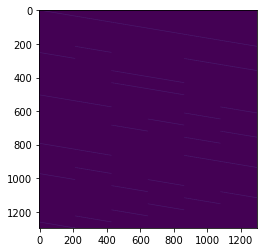

In [7]:
pylab.imshow((P_raw))
pylab.show()

In [8]:
np.min(np.sum(P_raw, axis=1)), np.max(np.sum(P_raw, axis=1))

(0.9999999999999609, 1.0000000000000455)

In [9]:
P_stoch = P_raw

In [10]:
b0 = np.ones(P_stoch.shape[0])
for i in range(1000):
    b_new = np.dot(b0, P_stoch)
    print(np.max(np.abs(b0 - b_new)))
    b0 = b_new

2.281006346860014
5.937531929335023
11.138236963818436
6.135613059855444
3.7682405717583514
2.2397741070575954
1.1980236477262238
0.6440401204213728
0.348060663616657
0.18678187781406308
0.1000875430606527
0.053660621363569305
0.028759246394251647
0.015409879993072195
0.008257028392613108
0.00442427467220341
0.0023705571867864705
0.0012701553174281344
0.0006805542339591852
0.0003646429338957091
0.0001953765811393282
0.00010468323137047264
5.608951166635734e-05
3.005288382951221e-05
1.6102400749673507e-05
8.627701305385926e-06
4.622741052173751e-06
2.476874655599204e-06
1.327114802052165e-06
7.11070988757001e-07
3.8099337729136096e-07
2.041370805727638e-07
1.0937709049585465e-07
5.860448482053471e-08
3.140041826554807e-08
1.6824408533011592e-08
9.014563318032742e-09
4.830027933167003e-09
2.587938752185437e-09
1.3866312542631931e-09
7.42957695365476e-10
3.9808156770959613e-10
2.1330492927518208e-10
1.1429079904701211e-10
6.124167839516304e-11
3.281996896475903e-11
1.759303813742008e-11
9

7.105427357601002e-15
7.105427357601002e-15
1.4210854715202004e-14
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
1.4210854715202004e-14
7.105427357601002e-15
1.4210854715202004e-14
7.105427357601002e-15
7.105427357601002e-15
3.552713678800501e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
3.552713678800501e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
1.4210854715202004e-14
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.105427357601002e-15
7.1054

In [11]:
xs = []
ys = []
density = []
summ = 0
summ_d = 0
for i in range(partition_n):
    p = partition[i]
    mid = (p[0] + p[1] + p[2]) / 3
    mid_s = np.sort(mid)
    summ += get_area(p) * b0[i]
    summ_d += 1 / (2 * mid_s[1] * (1 - mid_s[1]) * (1 - mid_s[0] - mid_s[1])) * get_area(p)
    xs.append(bar_to_coord(mid)[0])
    ys.append(bar_to_coord(mid)[1])
    density.append(1 / (2 * mid_s[1] * (1 - mid_s[1]) * (1 - mid_s[0] - mid_s[1])))
xs = np.array(xs)
ys = np.array(ys)
density = np.array(density)

In [12]:
summ, summ_d

(6.827168097871249, 4.56021706627227)

In [13]:
b0 = b0 / summ

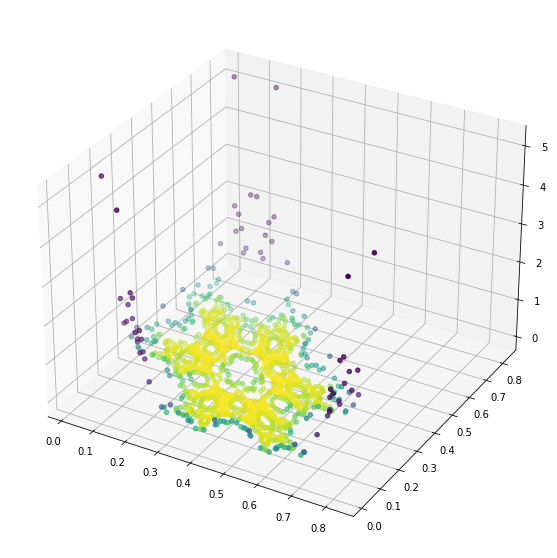

In [14]:
# !matplotlib notebook c=(0.1 ** b0)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, b0, c=(0.1 ** b0))
# for angle in range(0, 180):
#     ax.view_init(0, angle)

plt.savefig("./InvariantPoincare" + str(depth) + "_1.png")
plt.show()

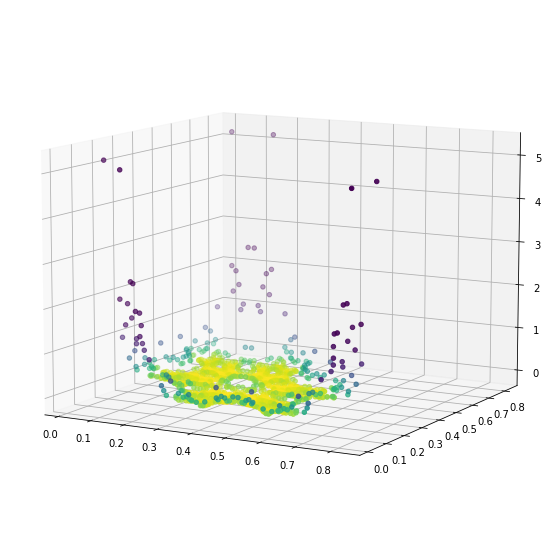

In [15]:
# !matplotlib notebook c=(0.1 ** b0)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, b0, c=(0.1 ** b0))
for angle in range(0, 300):
    ax.view_init(10, angle)

plt.savefig("./InvariantPoincare" + str(depth) + "_2.png")
plt.show()

### Code for visualizing partition

In [16]:
part = get_partition_vertices(depth)
len(part)

1296

In [17]:
def to_polygon(triag):
    x = []
    y = []
    for p in triag:
        p1 = bar_to_triag(p)
        x.append(p1[0])
        y.append(p1[1])
    return [x, y]

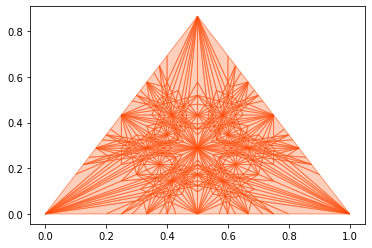

In [18]:
for p in part:
    plt.fill(to_polygon(p)[0], to_polygon(p)[1], facecolor='lightsalmon', edgecolor='orangered', alpha=0.5)
plt.savefig("./PartitionPoincare" + str(depth) + ".png")